# CSC413 Lab 6: GradCAM and Input Gradients

We have seen that convolutional neural networks (CNN) are successful in
many computer vision tasks, including classification, object detection
and others. However, it is not immediately clear how CNNs work, and how
one can explain the predictions made by CNNs.
A deeper understanding of how CNNs work can also help us identify reasons
why CNNs may fail to produce correct predictions for some samples.

A line of work started to visualize and interpret computed features of
convolutional neural networks. CAM and Grad-CAM are two influential and
fundamental works to find which parts of the input have the most impact
on the final output of the models by analyzing the model's extracted
feature maps.

By the end of this lab, you will be able to:

1. Explain how visualizing the regions of an image that contribute to the
   CNN model's prediction can help explain how the model works.
2. Implement CAM on a convolutional neural network with GAP + a single fc layer.
3. Explain the limitations of CAM, and how Grad-CAM overcomes this limitation.
4. Implement Grad-CAM on a convolutional neural network.

Acknowledgements:
1. We have borrowed some codes from [CAM Official Repo](https://github.com/zhoubolei/CAM).
2. We have borrowd texts, figures and formulas from main papers of [CAM](https://arxiv.org/pdf/1512.04150v1.pdf) and [Grad-CAM](https://arxiv.org/pdf/1610.02391.pdf).

## Submission

If you are working with a partner, start by creating a group on Markus.
If you are working alone,
click "Working Alone".

Submit the a PDF of your solution `lab09.pdf` as well as the ipynb on Markus
**containing all your solutions to the Graded Task**s.
Your file must contain your code **and outputs** where applicable,
including printed lines and images.

If the direct PDF export looks wrong with unnecessary whitespace, one good workaround is to export as HTML and then print the resulting webpage as a PDF. Sometimes the jupyter PDF export doesn't work perfectly.

For this lab, you should submit the following:

- Part 1. Your implementation of the `predict` function (1 point)
- Part 1. Your implementation of the `get_resnet_features` function (1 point)
- Part 1. Your implementation of the `compute_cam` function (3 point)
- Part 1. Your interpretation of the grad cam outputs (2 point)
- Part 2. Your implementation of the `compute_gradcam` function (3 point)


## Part 1. Class Activation Maps (CAM)

CAM and its extension Grad-CAM takes the approach of identifying the regions
of the an image that contributes most to the model's prediction.
This information can be visualized as a heat map, and provides a way to interpret
a model's prediction: did the model predict that the image is that of a "boat"
because of the shape of the ears, or because of the water in the background?

We discussed, during lecture, that convolutional layers preserve the geometry
of the image, and that these convolutional layers actually behave as feature/
object detectors of various complexity.
Since the geometry of the output of a CNN layer corresponds to the geometry of
input image, it is straightforward to locate the region of the image that corresponds
to a particularly high activation value.
This is because the computations that we use in a CNN (convolutions, max pooling,
activations) are all geometry preserving (equivariant).

However, fully-connected layers are typically used for classification in the final
layers of a CNN.  These fully-connected layers are **not** geometry preserving,
thus information about the locations of discriminating features are lost
when fully-connected layers are used for classification.

The idea behind CAM is to avoid using these fully-connected layers for
classification, so that we can reconstruct location information in a straightforward
way. Instead of fully-connected layers, we use:

1. A global average pooling (GAP) layer. This layer will take as input the output of a
   CNN layer (e.g., of shape `H x W x C`) and perform an average operation for each
   *channel* along the entire activation height/width (producing an output vector
   of shape `C`).
2. A single linear layer to map this vector (of length `C`) into the output space.

Since both the pooling and linear layers have straightforward computation, it is possible
to assign credit for a output score for a class back to specific activation values
of the CNN output.

The framework of the Class Activation Mapping is as below (from https://github.com/zhoubolei/CAM):

<img src="https://camo.githubusercontent.com/ef86405fc14b4af391c891c93a50ce92c8bfc3f8fae6e7c04f5f7185b21c3eca/687474703a2f2f636e6e6c6f63616c697a6174696f6e2e637361696c2e6d69742e6564752f6672616d65776f726b2e6a7067" width="500px"/>

In this part of the lab, we will implement CAM to produce a heatmap of the
contribution to locations in the image to a predicted class.
We will use the pre-trained convolutional neural network **ResNet**,
chosen because this model's architecture uses global average pooling (GAP).
ResNet is trained on the ImageNet data set.

In [ ]:
from torchvision import models, transforms
import torch.nn.functional as F
import torch
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Download resnet pretrained weights
resnet = models.resnet18(pretrained=True)

# CAM can only be used when the models are in "evaluation phase".
resnet.eval()

# Print model architecture
# We will use the CNN activations computed after layer 4, and before GAP.
resnet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 30.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The ImageNet labels are a bit challenging to read. We will download a list of human-readable
labels from here:

In [ ]:
!wget https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

--2024-03-22 17:42:05--  https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14209 (14K) [text/plain]
Saving to: ‘imagenet-simple-labels.json’

imagenet-simple-lab 100%[===================>]  13.88K  --.-KB/s    in 0s      

2024-03-22 17:42:05 (53.3 MB/s) - ‘imagenet-simple-labels.json’ saved [14209/14209]



In [ ]:
# Load the imagenet category list
with open('imagenet-simple-labels.json') as f:
    classes = json.load(f)

To remind ourselves of how ResNet works, let's predict what class these images belongs to:

<img src="https://www.cs.toronto.edu/~lczhang/413/cat.jpg" width="300px" />
<img src="https://www.cs.toronto.edu/~lczhang/413/boat.jpg" width="300px" />

In [ ]:
!wget https://www.cs.toronto.edu/~lczhang/413/cat.jpg
!wget https://www.cs.toronto.edu/~lczhang/413/boat.jpg

--2024-03-22 17:42:09--  https://www.cs.toronto.edu/~lczhang/413/cat.jpg
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 986734 (964K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>] 963.61K  4.83MB/s    in 0.2s    

2024-03-22 17:42:10 (4.83 MB/s) - ‘cat.jpg’ saved [986734/986734]

--2024-03-22 17:42:10--  https://www.cs.toronto.edu/~lczhang/413/boat.jpg
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874117 (854K) [image/jpeg]
Saving to: ‘boat.jpg’

boat.jpg            100%[===================>] 853.63K  4.28MB/s    in 0.2s    

2024-03-22 17:42:10 (4.28 MB/s) - ‘boat.jpg’ saved [874117/874117]



In [ ]:
from PIL import Image

def process_input(image_file):
    # open the image
    img = Image.open(image_file)

    # transform the images by resizing and normalizing
    preprocess = transforms.Compose([
       transforms.Resize((224,224)),
       transforms.ToTensor(),
       transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225])])

    return preprocess(img).unsqueeze(0)

**Graded Task**: Write a function that takes a model and an image file and produces a list of the
top 5 predictions with the corresponding probability score.

In [ ]:
def predict(model, image_file):
    """
    Return the top 5 class predictions with the corresponding probability score.

    Parameters:
        `model`      - nn.Module
        `image_file` - file path to the image

    Returns: a list of 5 (string, int, float) pairs:
        the string is the predicted ResNet class name (see classes above),
        the int is the predicted ResNet class id,
        and the float is the prediction probability. The list should be ordered
        so that the highest probabilty score appears first.

    Example:
        >>> predict(resnet, 'cat.jpg')
        [('prison', 743, 0.23517875373363495),
         ('shopping cart', 791, 0.07393667101860046),
         ('rocking chair', 765, 0.06884343922138214),
         ('wheelbarrow', 428, 0.06603048741817474),
         ('ring-tailed lemur', 383, 0.0434008426964283)]
    """
    x = process_input(image_file)

    # Ensure model is in evaluation mode
    model.eval()
    # Get model output
    outputs = model(x)
    # Apply softmax
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    # Get the top 5 predictions
    top_probs, top_indices = torch.topk(probabilities, 5)
    # Convert top probabilities and indices to lists
    top_probs = top_probs.flatten().tolist()
    top_indices = top_indices.flatten().tolist()
    # Map them: class name, top index, top prob
    result = [(classes[index], index, prob) for index, prob in zip(top_indices, top_probs)] # TODO

    return result

Please include the output of the below cell in your submission.

In [ ]:
predict(resnet, 'cat.jpg')

[('prison', 743, 0.23517875373363495),
 ('shopping cart', 791, 0.07393667101860046),
 ('rocking chair', 765, 0.06884343922138214),
 ('wheelbarrow', 428, 0.06603048741817474),
 ('ring-tailed lemur', 383, 0.0434008426964283)]

Now that we can use ResNet to make predictions, we need two additional pieces
of information for CAM.

First, given an image, we need to be able to compute the
**features/activations of the last convolutional layer**. This feature map
is the input to the GAP layer. Although this information is computed in a
forward pass, we will need to write some code to extract this information.

Second, we will need the weights of the final fully-connected layer in ResNet.

**Graded Task**: Complete the following function that takes an image file and produces the
weights of the finally fully-connected layer in Resnet.
You may find the `named_children()` method of resnet helpful, as it produces a
sequence of (named) layers. We would like the feature map directly before the
global average pooling layer.

In [ ]:
for (name, model) in resnet.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
def get_resnet_features(image_file):
    """
    Return the final CNN layer (layer4) feature map in resnet

    Parameters:
        `image_file` - file path to the image

    Returns: PyTorch tensor of shape [1, 512, 7, 7]
    """

    x = process_input(image_file)

    result = None # TODO
    for (name, model) in resnet.named_children():
        # TODO -- update result
        x = model(x)
        if name == 'layer4':
            break
    result = x
    return result

In [ ]:
fets = get_resnet_features('cat.jpg')
print(fets.shape) # should be [1, 512, 7, 7]

torch.Size([1, 512, 7, 7])


**Task**: Assign the variable `fc_weight` to the
weights of the final fully-connected layer in resnet.

In [ ]:
weights = resnet.fc.weight.data # TODO
print(weights.shape) # should be [1000, 512]

torch.Size([1000, 512])


**Graded Task**: Complete the function `compute_cam`, which takes the
CNN feature map (from the `get_resnet_features` function), the ImageNet label of
interest, and produces a heat map of the features that contribute to the
label score according to the following approach.

We will use the notation ${\bf X}$ to denote the CNN feature map (the input to the GAP),
with $X_{i,j,c}$ being the activation at location $(i, j)$ and channel $c$.
Here, ${\bf X}$ is a tensor with shape $H \times W \times C$, where $H \times W$ is
the height and width of the feature map and $C$ is the number of channels.
We will use the vector ${\bf h}$ to denote the output of the GAP,
so that $h_c = \frac{1}{HW} \sum_{i=1}^{H} \sum_{j=1}^{W} X_{i,j,c}$.
Finally, we will use ${\bf W}$ to denote the finally fully connected layer weights,
and ${\bf z}$ to the denote the prediction score,
so that ${\bf z} = {\bf W}{\bf h}$.

Now, we would like to relate the features $X_{i,j,c}$ to the scores $z_k$, so that
we can compute the contribution of the features at position $(i,j)$ to the score
$k$.

For an output class $k$, we have:

$$z_k  = \sum_{c=1}^{C} w_{k,c} h_c$$

Substituing $h_c$ for its definition, we have:

$$z_k  = \sum_{c=1}^{C} w_{k,c} \frac{1}{HW} \sum_{i=1}^H \sum_{j=1}^W X_{i,j,c}$$

Rearranging the sums, we have:

$$z_k  = \frac{1}{HW} \sum_{i=1}^H \sum_{j=1}^W \sum_{c=1}^C w_{k,c} X_{i,j,c}$$

The inner term $\sum_c w_{k,c} X_{i,j,c}$ is exactly what we are looking for:
this term indicates how much the value in location $(i, j)$ of
the feature map ${\bf X}$ attributes to class $k$.

In [ ]:
def compute_cam(features, label):
    """
    Computes the contribution of each location in `features` towards
    `label` using CAM.

    Parameters:
        `features`: PyTorch Tensor of shape [1, 512, 7, 7] representing
                    final layer feature map in ResNet (e.g., from calling
                    `get_resnet_features`)
        `label`   : resnet label, integer between 0-999

    Returns: PyTorch Tensor of shape [7, 7]
    """
    features = features.squeeze(0) # remove the first dimension
    # we need the weight data
    label_weights = weights[label]
    # multiply each feature map with its corresponding weight and then sum all
    # to get CAM (need to reshape features to (512, 7*7))
    cam = torch.matmul(label_weights, features.reshape(512, 49))
    # then change shape of cam to (7, 7)
    cam = cam.reshape(7, 7)
    result = F.relu(cam) # TODO
    return result

**Task**: Run the below code, which superimposes the result of the `compute_cam`
operation on the image.

In [ ]:
def visualize_cam(image_file, label):
    # open the image
    img = Image.open(image_file)

    # compute CAM features
    fets = get_resnet_features(image_file)
    m = compute_cam(fets, label)

    # normalize "m"
    m = m - m.min()
    m = m / m.max()
    # convert "m" into pixel intensities
    m = np.uint8(255 * m.detach().numpy())
    # apply a color map
    m = cv2.resize(m, img.size)
    heatmap = cv2.applyColorMap(m, cv2.COLORMAP_JET)

    plt.figure(figsize=(6, 6))
    plt.title("%s %s" % (image_file, classes[label]))
    plt.imshow((0.3 * heatmap + 0.5 * np.array(img)).astype(np.uint8)) # superimpose heat map on img
    plt.show()

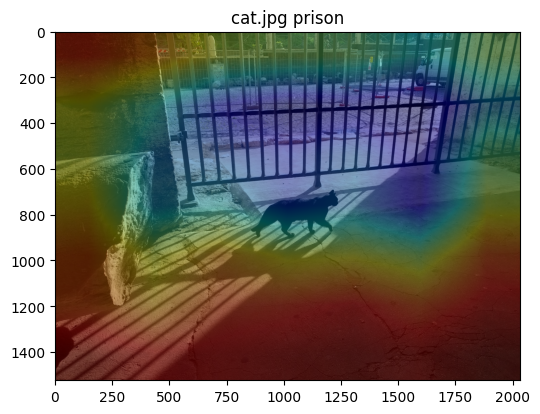

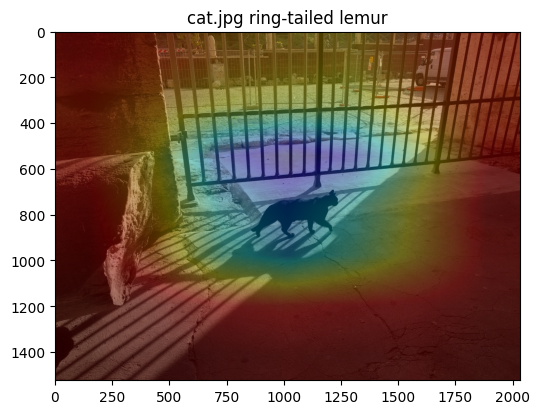

In [ ]:
visualize_cam('cat.jpg', 743)
visualize_cam('cat.jpg', 383)

**Graded Task** Compare the above two outputs, and explain what conclusion you
may be able to draw about the contribution of the pixel locations to those
two classes. Why do you think the model misclassified the image?

In [ ]:
# There are several parts of the original image. The first image is focusing on the fences,
# thus the model has higher probability to predict it as a prison. The second image focuses
# on the cat, and that may be the reason it is classified as a similar animal, lemur.
# The reason the model misclassifies the image might be because it weighs some pixel location
# higher than other parts.

## Part 2. Grad-CAM

Although CAM was an important step toward understanding convolutional neural networks,
the technique is only applicable to convolutional networks with GAP and
a single fully-connected layer.  Recall that it leveraged the following relationship
between the output of the GAP layer ${\bf h}$ and the score for the output class
$z_k$:

$$z_k  = \sum_c w_{k,c} h_c$$

Where $w_{k,c}$ is the fully connected layer weight that describes the strength of the
connection between $h_c$ and $z_k$. In other words, $w_{k,c}$ describes the following
gradient:

$$\frac{\partial z_k}{\partial h_c}$$

With this in mind, you may be able to see how CAM may be generalized so that
${\bf z}$ may be a more complex function of ${\bf h}$---e.g., a MLP or even an RNN!

Gradient-weighted Class Activation Mapping (Grad-CAM) is a generalized form of CAM,
and can be applied to any convolutional neural network.
In Grad-CAM, we use the gradient $\frac{\partial z_k}{\partial h_c}$
in place of $w_{k,c}$ when attributing class scores to locations $(i, j)$.
In other words, the below term indicates how much the value in location $(i, j)$ of
the feature map ${\bf X}$ attributes to class $k$.

$$ReLU(\sum_c \frac{\partial z_k}{\partial h_c} X_{i,j,c})$$

The addition of the ReLU activation only allows positive contributions to be visualized.

Sidenote: To generalize this result even further, we can replace $z_k$ with any target we would like!
Grad-CAM has been used on neural networks that performs image caption
generation: a model with a CNN *encoder* and an RNN *decoder*.
We can use use the gradients of any
target concept (say "dog" in a classification network or a sequence of words
in a captioning network) flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept. Taking a look at [this video](https://www.youtube.com/watch?v=COjUB9Izk6E) helps you to understand the power of Grad-CAM.

Let's explore GradCAM with the VGG network:

In [ ]:
vgg19 = models.vgg19(pretrained=True)
vgg19.eval()
vgg19

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 58.7MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
predict(vgg19, 'cat.jpg')

[('prison', 743, 0.9434548616409302),
 ('giant panda', 388, 0.018725549802184105),
 ('skunk', 361, 0.00620967848226428),
 ('patio', 706, 0.003032147651538253),
 ('jaguar', 290, 0.002576682949438691)]

**Task** Just like with CAM, we will need to extract the feature map obtained from the last
convolutional layer. This step is actually very straightforward with VGG since `vgg19` splits the
network into a `features` network and a `classifier` network.

In [ ]:
def get_vgg_features(image_file):
    """
    Return the output of `vgg19.features` network for the image

    Parameters:
        `image_file` - file path to the image

    Returns: PyTorch tensor of shape [1, 512, 7, 7]
    """

    x = process_input(image_file)
    result = vgg19.features(x) # TODO
    return result

In [ ]:
get_vgg_features('cat.jpg').shape

torch.Size([1, 512, 7, 7])

**Task**: Read the forward method of the VGG model here. https://github.com/pytorch/vision/blob/main/torchvision/models/vgg.py
What other steps are remaining in the forward pass?

In [ ]:
# TODO:
# We've done the first step:
# x = self.features(x)
# The remaining steps are:
# x = self.avgpool(x) which is average pooling, which reduces the dimensionality
# and prepares the tensor for the fully connected layers.
# x = torch.flatten(x, 1) which flattens the tensor from the second dimension.
# x = self.classifier(x) which will return the classification vector for the flattened tensor
# Then, the classifier would be returned.


**Graded Task**: Complete the function `compute_gradcam`, which takes an
image file path, the ImageNet label of
interest, and produces a heat map of the features that contribute to the
label score according to the GradCAM approach described at the beginning of
Part 2.

In [ ]:
def compute_gradcam(image_file, label):
    """
    Computes the contribution of each location in `features` towards
    `label` using GradCAM.

    Parameters:
        `image_file` - file path to the image
        `label`   : resnet label, integer between 0-999

    Returns: PyTorch Tensor of shape [7, 7]
    """
    # obtain the image input features
    x = process_input(image_file)

    # obtain the output of the features network in the CNN
    fets = vgg19.features(x)

    # tell PyTorch to compute the gradients with respect
    # to "fets"
    fets.retain_grad()

    # TODO: compute the rest of the vgg19 forward pass from `fets`
    result_after_fets = vgg19.avgpool(fets)
    flatten_fets = torch.flatten(result_after_fets, 1)
    out = vgg19.classifier(flatten_fets) # should be the output of the classifier network

    z_k = out.squeeze(0)[label] # identify the target output class
    z_k.backward()              # backpropagation to compute gradients

    features_grad = fets.grad   # identify the gradient of z_k with respect to fets

    # account for the pooling operation, so that "pooled_grad"
    # aligns with the notation used
    n, c, h, w = features_grad.shape
    features_grad = torch.reshape(features_grad, (c, h*w))
    pooled_grad = features_grad.sum(dim=1)

    # rearrange "fets" so that "X" aligns with the notation
    # used above
    X = fets.squeeze(0).permute((1, 2, 0))

    # TODO: Compute the heatmap using the gradcam
    m = torch.sum(pooled_grad.view(c, 1, 1) * X, dim=1).squeeze(0)
    m = F.relu(m) # apply the ReLU operation
    return m

**Task**: Run the below code, which superimposes the result of the `compute_gradcam`
operation on the image.

In [ ]:
def visualize_gradcam(image_file, label):
    # open the image
    img = Image.open(image_file)

    # compute CAM features
    m = compute_gradcam(image_file, label)

    # normalize "m"
    m = m - m.min()
    m = m / m.max()
    # convert "m" into pixel intensities
    m = np.uint8(255 * m.detach().numpy())
    # apply a color map
    m = cv2.resize(m, img.size)
    heatmap = cv2.applyColorMap(m, cv2.COLORMAP_JET)

    plt.figure(figsize=(6, 6))
    plt.title("%s %s" % (image_file, classes[label]))
    plt.imshow((0.3 * heatmap + 0.5 * np.array(img)).astype(np.uint8)) # superimpose heat map on img
    plt.show()

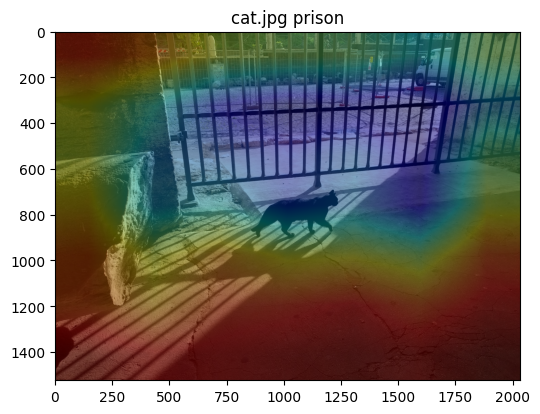

In [ ]:
visualize_cam('cat.jpg', 743)

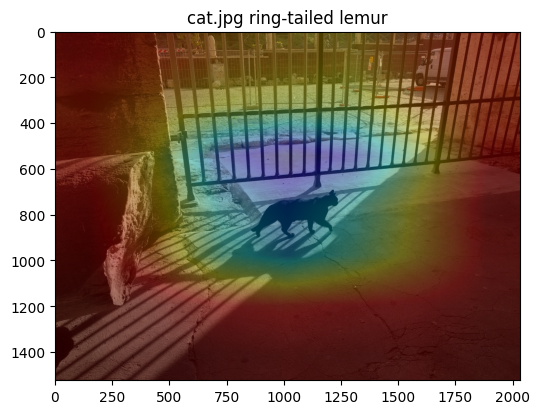

In [ ]:
visualize_cam('cat.jpg', 383)

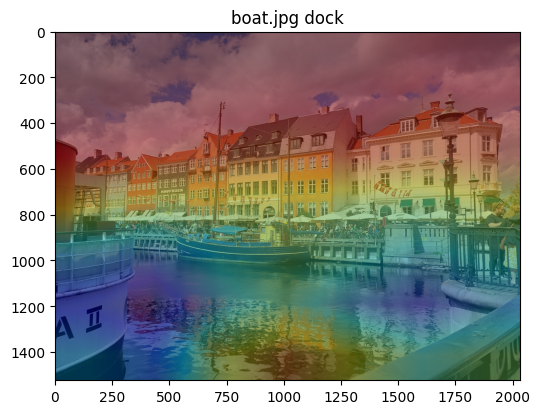

In [ ]:
visualize_cam('boat.jpg', 536)

## Just For Fun

As you might have seen in the [video](https://www.youtube.com/watch?v=COjUB9Izk6E),
Grad-CAM can be applied to text-generating models. For example, in image-captioning
tasks, a text is generated describing the given image. Some methods first feed the
image to a convolutional neural network to extract features, and then feed the extracted
features to an RNN, to generate the text. Neuraltalk2 was one of the earliest models
using this approach. Similar to the classification task, it is enough to compute the
gradient of the score (what is the score in an image-captioning task?) with respect
to the last convolutional layer.

If you are interested in how neuraltalk2 functions you can check [this project](https://cs.stanford.edu/people/karpathy/deepimagesent/). Moreover, if you are looking for more hands-on experience, [this repo](https://github.com/ruotianluo/ImageCaptioning.pytorch) has implemented many image-captioning methods, and you can easily apply Grad-CAM on them (especially show and tell).

Hint: There is a file which re-implements the forward pipeline of ResNet101, where you can store the features.